In [1]:
import os
os.chdir("/users/PAS0027/xiong336/project/trajectory")
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from util.args import parse_args
from util.configs import Config
from util.data import TrajectoryDeltaDataset, standardization
from train import load_checkpoint
from eval.util import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
DataLoader(range(10),)

SyntaxError: keyword argument repeated (<ipython-input-3-58efabd6b0f9>, line 1)

In [2]:
def get_data(cfgObj, **kwargs):
  dataset = TrajectoryDeltaDataset(**cfgObj.get_dataset_param(), input_trans=None)
  return dataset

def get_model(model_path, args, **kwargs):
  nncfg = Config(args.nncfg)
  ckpt = load_checkpoint(model_path, nncfg)
  model = ckpt['model']
  return model

In [3]:
def inference(model, dataset, loader_params):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  dataloader = DataLoader(dataset, **loader_params)
  
  inputs = []
  preds = []
  gts = []
  with torch.no_grad():
    for data in dataloader:
      pos_time = data[0].to(device)
      pred = model(pos_time)

      # accumulate complete data
      inputs.append(pos_time.detach().cpu())
      preds.append(pred.detach().cpu())
      gts.append(data[1])
  
  inputs = torch.concat(inputs, 0)
  preds = torch.concat(preds, 0)
  gts = torch.concat(gts, 0)

  print(f'\nSHAPES: ',inputs.shape, preds.shape, gts.shape ,'\n')
  preds = inputs + preds
  gts = inputs + gts

  return inputs.numpy(), preds.numpy(), gts.numpy()

In [4]:
cfgObj = Config('cfg/nntest.yaml')
cfg = cfgObj.config
out_dir = cfg['out_dir']
vis_out_dir = cfg['vis_out_dir']

# get data
ds_param = cfgObj.get_dataset_param()
fp = os.path.join(ds_param['data_dir'], ds_param['file_name'])
fp_len = os.path.join(ds_param['data_dir'], ds_param['len_file_name'])
traj = np.load(fp)
traj_len = np.load(fp_len)
traj = traj[:, :, ds_param['in_idx']]

In [ ]:
# get model
model_path = cfg['model_path']
nncfg = Config('cfg/nn.yaml')
ckpt = load_checkpoint(model_path, nncfg)
model = ckpt['model']

In [9]:
traj = traj[:, :, ds_param['in_idx']]

In [83]:
traj_idx = torch.randint(0, traj.shape[0], (16,))

In [84]:
starts = torch.tensor(traj[traj_idx, 0, :])
traj_pred = [starts]
for t in range(500):
  t_tensor = torch.zeros(starts.shape[0]).unsqueeze(-1) + t
  net_input = torch.concat([starts, t_tensor], dim=-1)
  starts += model(net_input)
  traj_pred.append(starts)

traj_pred = torch.concat(traj_pred).view(len(traj_idx), -1, 3)
traj_gt = traj[traj_idx, :101, :]
traj_pred_np = traj_pred.detach().cpu().numpy()

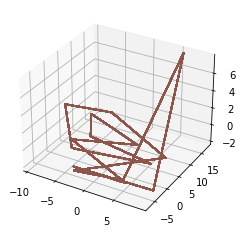

In [85]:
# Data for a three-dimensional line
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(traj_pred_np.shape[0]):
  ax.plot3D(traj_pred_np[i, :, 0], traj_pred_np[i, :, 1], traj_pred_np[i, :, 2])
plt.show()

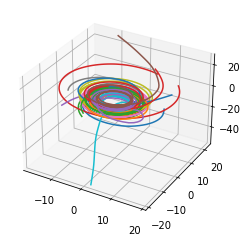

In [86]:
# Data for a three-dimensional line
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(traj_pred_np.shape[0]):
  ax.plot3D(traj_gt[i, :, 0], traj_gt[i, :, 1], traj_gt[i, :, 2])
plt.show()

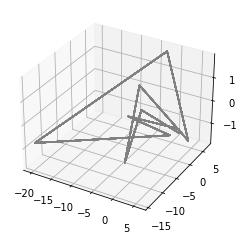

In [67]:
fig = plt.figure()
ax = plt.axes(projection='3d')
line_idx = 0
ax.plot3D(traj_pred_np[line_idx, :, 0], traj_pred_np[line_idx, :, 1], traj_pred_np[line_idx, :, 2], 'gray')

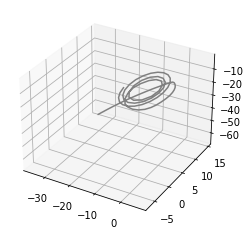

In [59]:
fig = plt.figure()
ax = plt.axes(projection='3d')
line_idx = 5
ax.plot3D(traj_gt[line_idx, :, 0], traj_gt[line_idx, :, 1], traj_gt[line_idx, :, 2], 'gray')

In [45]:
traj_pred[0, :, 0].shape

torch.Size([101])

In [40]:
traj_gt.shape

(10, 101, 3)

In [41]:
traj_pred.shape

torch.Size([10, 101, 3])